In [1]:
import numpy as np
import scipy
from astropy.io import fits
from matplotlib import pyplot as plt

from scipy import optimize
from scipy.spatial import distance
import scipy.ndimage as ndimage

import lsst.afw.image as afwImage
from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd

from lsst.eotest.sensor.spotTask import SpotTask, make_ccd_mosaic

## 1. Constructing a Calibrated Image

During the previous testing period, some CCDs in the LSST Camera were illuminated, using a specially designed projector, with a grid of spots that resemble the size and shape of stars. We would like to use these images in order to study how true astronomical objects might be stretched, shifted, or distorted by "instrumental effects". 

The first step is to produce a calibrated image, using a series of steps referred to as the data reduction process:

* Bias and overscan subtraction
* Gain correction
* Dark current subtraction

First, let's read in an image file and print the main header.

In [3]:
infile = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/' + \
         'LCA-11021_RTM/LCA-11021_RTM-002_ETU1/5808D/qe_raft_acq/v0/38319/S11/' + \
         'ITL-3800C-107_lambda_flat_0450_5808D_20180317235805.fits'

hdulist = fits.open(infile)
print(repr(hdulist[0].header))

SIMPLE  =                    T / Java FITS: Thu Mar 15 12:52:46 PDT 2018        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2018-03-17T23:58:10.533' / Creation Date and Time of File            
DATE-OBS= '2018-03-17T23:58:05.484' / Date of the observation (image acquisition
MJD     =    58194.99873302085 / Modified Julian Date that the file was written 
MJD-OBS =  58194.998674583156 / Modified Julian Date (5 decimal places) of image
RUNNUM  = '5808D   '           / The Run Number                                 
IMAGETAG= '1521331085484'      / Image tag (CCS/VST)                            
TSTAND  = 'TS8     '           / Which Test stand at the site was used          
CONTNUM = '000018ee3b40'       / CCD Controller Serial Number                   
SEQFILE = 'itl-2s-200ohm.seq

The FITs file is read in as an `hdulist` object.  This is a list of `HDU` objects, each consisting of a `header` and `data`.  The first `HDU` is just a `header` (above) and "empty" `data`, containing information about the image testing conditions and the CCD sensor used.  The next 16 contain specific amplifier information in their headers, and a corresponding amplifier image.  The remaining are additional testing information headers.

Text(0.5, 0, 'Pixel')

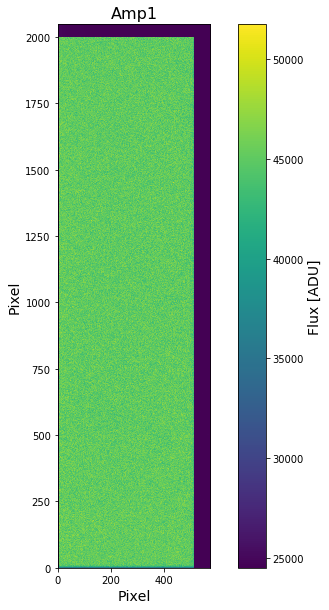

In [4]:
## Select amplifier to plot (1-16)
amp_num = 1
amp = hdulist[amp_num].data

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cax = ax.imshow(amp, origin='lower')
cbar = fig.colorbar(cax)
cbar.set_label('Flux [ADU]', fontsize=14)
ax.set_title('Amp{0}'.format(amp_num), fontsize=16)
ax.set_ylabel('Pixel', fontsize=14)
ax.set_xlabel('Pixel', fontsize=14)

A number of features can be seen in this amplifier image:
1. The signal is reported in "ADU" or analog-digital-units.  These can be thought of as unit-less counts.  For most of our studies we are interested in the signal level in "electrons".  To convert from ADU to electrons, you will need to know the conversion factor, or "gain", which has units of electrons/ADU.  Each of the 16 amplifiers will have a unique gain that will be needed to properly combine them into a single image.
2. The "edge" pixels are at a much lower signal level. These are the "overscan" pixels, which do not correspond to physical light-collecting pixels on the detector.  Additionally, these pixels are not ~0 ADU, but rather offset by an amount.  By measuring the signal in the overscan pixels we can remove this offset (which is also present in the physical pixels), in the process of overscan correction.  

To get a full CCD image, we'll take all the amplifiers and put them together (removing the overscan regions) into a single array.  Additionally, we can perform the calibration steps by including a `bias_frame`, a `dark_frame`, and/or a `gains` dictionary.

The machinery that performs the above operations is nicely wrapped into the single function `make_ccd_mosaic()`, which performs the following:
* If a bias frame is included: overscan and bias correction
* If a dark frame is included: dark current correction
* If gains are included: gain correction

The return value is an `afwImage` object, but an array can be returned using the `afwImage.getArray()` method.  Many of the small deviations in the flat field image are hidden by the photon shot noise.  To tease out a signal, it is necessary to smooth the image using a Gaussian kernel.  Both the original and the smoothed image are plotted below.

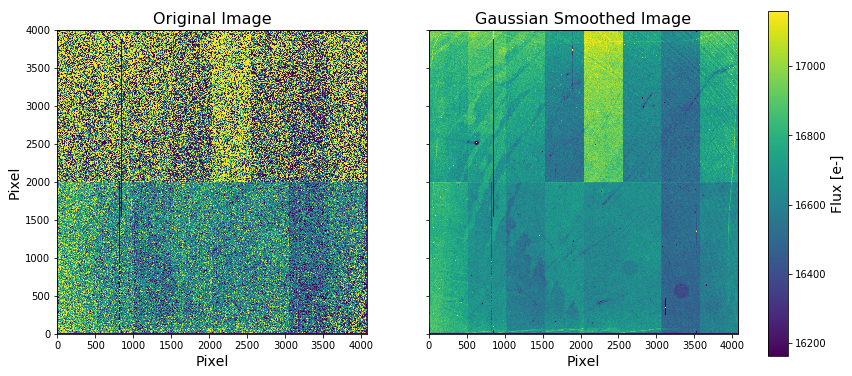

In [5]:
## Get image file
infile = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/' + \
         'LCA-11021_RTM/LCA-11021_RTM-002_ETU1/5808D/qe_raft_acq/v0/38319/S11/' + \
         'ITL-3800C-107_lambda_flat_0450_5808D_20180317235805.fits'

## Get dark file from same eotest run
dark_frame = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/' + \
             'LCA-11021_RTM/LCA-11021_RTM-002_ETU1/5808D/dark_raft_acq/v0/38315/S11/' + \
             'ITL-3800C-107_dark_dark_000_5808D_20180317230231.fits'

## Get a bias file from same eotest run
bias_frame = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/' + \
            'LCA-11021_RTM/LCA-11021_RTM-002_ETU1/5808D/qe_raft_acq/v0/38319/S11/' + \
            'ITL-3800C-107_lambda_bias_000_5808D_20180317235634.fits'

## Get gains from the eotest run results
eotest_results = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/' + \
                 'LCA-11021_RTM/LCA-11021_RTM-002_ETU1/5808D/collect_raft_results/v0/38330/' + \
                 'ITL-3800C-107_eotest_results.fits'
hdulist = fits.open(eotest_results)
gain_results = hdulist[1].data['GAIN']
gains = {i+1 : gain for i, gain in enumerate(gain_results)}

ccd_image = make_ccd_mosaic(infile, bias_frame=bias_frame, dark_frame=dark_frame, gains=gains)

## Get image array
imarr = ccd_image.getArray()
im_mean = np.mean(imarr)

## Gaussian smoothed image sigma_x=sigma_y=2 
imarr_smoothed = ndimage.gaussian_filter(imarr, sigma=(2, 2), order=0)

## Plot images side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = ax[0].imshow(imarr, origin='lower', vmin=im_mean-500, vmax=im_mean+500)
ax[0].set_ylabel('Pixel', fontsize=14)
ax[0].set_xlabel('Pixel', fontsize=14)
ax[0].set_title('Original Image', fontsize=16)

im1 = ax[1].imshow(imarr_smoothed, origin='lower', vmin=im_mean-500, vmax=im_mean+500)
ax[1].set_title('Gaussian Smoothed Image', fontsize=16)
ax[1].set_xlabel('Pixel', fontsize=14)

## Add a global colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Flux [e-]', fontsize=14)

## Astrometric Distortions

The properties of astrophysical sources (stars, galaxies, etc.) in a particular image are held in a data table known as a source catalog.  This catalog records a number of properties (position, weighted moments, flux, etc) for each source identified in an image.  For camera integration and testing, the sources are "fake" sources, projected onto a single sensor using a custom optical light projector.  

Below is an example image of a grid of spots projected onto a single sensor.

In [7]:
catalog = '/u/ki/etabor/project/BOT_spotgrid_dither_example.cat'

## Print the column names
src = fits.getdata(catalog)
print(src.columns)

ColDefs(
    name = 'flags'; format = '84X'
    name = 'id'; format = '1K'
    name = 'coord_ra'; format = '1D'; unit = 'rad'
    name = 'coord_dec'; format = '1D'; unit = 'rad'
    name = 'parent'; format = '1K'
    name = 'base_SdssCentroid_x'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_y'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_xErr'; format = '1E'; unit = 'pixel'
    name = 'base_SdssCentroid_yErr'; format = '1E'; unit = 'pixel'
    name = 'base_SdssShape_xx'; format = '1D'; unit = 'pixel^2'
    name = 'base_SdssShape_yy'; format = '1D'; unit = 'pixel^2'
    name = 'base_SdssShape_xy'; format = '1D'; unit = 'pixel^2'
    name = 'base_SdssShape_xxErr'; format = '1E'; unit = 'pixel^2'
    name = 'base_SdssShape_yyErr'; format = '1E'; unit = 'pixel^2'
    name = 'base_SdssShape_xyErr'; format = '1E'; unit = 'pixel^2'
    name = 'base_SdssShape_x'; format = '1D'; unit = 'pixel'
    name = 'base_SdssShape_y'; format = '1D'; unit = 'pixel'
    name =

To get an idea of how this relates to a CCD image, I have plotted the X/Y position of each source in the catalog, as well as using a color representation for one of the flux measurements.  Overlayed is the CCD amplifier geometry, to show where the sources fall on the actual sensor.

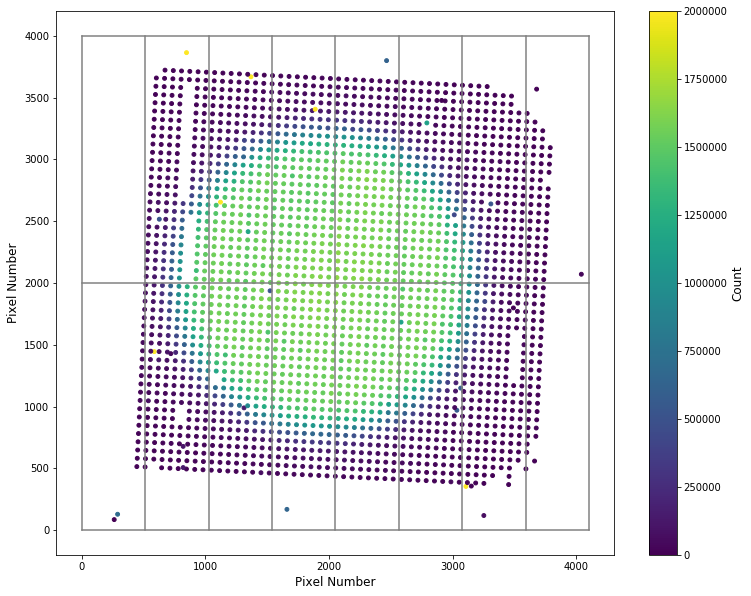

In [8]:
## Get x/y/z arrays from the source catalog.
X = src['base_SdssShape_x']
Y = src['base_SdssShape_y']
Z = src['base_SdssShape_instFlux']

## Scatter plot x/y positions and flux value as the color parameter
fig, ax = plt.subplots(1, 1, figsize=(12.5, 10))
cax = ax.scatter(X, Y, c=Z, marker='o', s=15, vmin=0.0, vmax=2000000.)
ax.set_ylabel('Pixel Number', fontsize=12)
ax.set_xlabel('Pixel Number', fontsize=12)
cbar = fig.colorbar(cax)
cbar.set_label('Count', fontsize=12)

## Plot the CCD amplifier geometry (for an ITL sensor)
for i in range(3):
    ax.plot(np.asarray([0, 513*8]), np.asarray([i*2000, i*2000]), 'grey')
for i in range(9):
    ax.plot(np.asarray([513*i, 513*i]), np.asarray([0, 4000]), 'grey')

As you can see these sources are not real stars, but rather a grid of star-like spots projected onto the camera.  The grid imaged on the sensor will have several differences from the photolithographic grid mask.
* Magnification of the grid, set by the optical system.
* Tilt (and skew?) caused by misalignment of the projector face with the camera focal plane.
* Rotation caused by the grid mask being rotated with respect to the sensor.
* Distortions caused by sensor effects. 

The project is then to start from an ideal grid and compare it to the measured grid (taking into account geometric distortions like magnification, rotation and tilt) to determine the distortions caused by sensor effects.